In [0]:
import numpy as np
import matplotlib.pyplot as pl
import sympy as sp
import matplotlib.pyplot as plt

Mf , af = sp.symbols("Mf af")

# Calibrating Outputs from EOB Inspirals to Backwards-One-Body

Author: Siddharth Mahesh

The Effective One Body(EOB) formalism allows for the generation of waveforms for the inspiral component of Binary Black Hole mergers. The merger-ringdown component of the corresponding waveform is modelled using the Backwards-One-Body(BOB) formalism.

In order to generate the BOB waveforms, the data obtained from EOB inspirals need to be represented in BOB-friendly inputs that can then be plugged into amplitude and phase functions to generate the waveform. The data from EOB inspirals are two-fold:

*   A Time-Series Waveform for the Inspiral terminating at the EOB prescribed Light Ring
*   Numerically Calibrated fits to the Mass and Spin of the Final Black Hole

We additionally prescribe a reference time, $t_0 = t_{p,h} - 10M$ where we attach the two waveforms.

## End State Quantities

The quantites we can compute from the end state include the damping time of Quasinormal Modes (QNM) and the frequency of QNMs sourced by the final black hole.
To do this, we first quote the frequency and quality factor of the (l,m) = (2,2)QNMs for a Kerr black hole with mass , dimensionless spin given by: $(M_f,a_f)$

$$
\omega = M_f^{-1}\left(1.5251 - 1.1568(1 - a_f)^{0.1292}\right)\\
Q = 0.7000 + 1.4187(1 - a_f)^{-0.4990}
$$

In [0]:
af_num = 0.6864
Mf_num = 0.9516

omqnm = 1.5251-1.1568*(1-af_num)**0.1292
omqnm = omqnm/Mf_num
Q = 0.7+1.4187*(1-af_num)**(-0.499)

The QNM frequency $\Omega_{QNM}$ and the damping time $\tau$ are then given by:

$$
\Omega_{QNM} = \frac{\omega}{2}\\
\tau = \frac{Q}{\Omega_{QNM}}
$$

In [0]:
Om_QNM_num = omqnm/2
tau_num = Q/Om_QNM_num

## Inspiral Quantities

The EOB time series contains in it 8 columns which are, in order



1.   Time, $t$
2.   $\mathfrak{Re}(h_{22})$
3.   $\mathfrak{Im}(h_{22})$
4.   $|h_{22}|$
5.   Phase , $\Phi$
6.   Orbital Frequency, $\omega$
7.   Orbital Frequency, $\omega$
8.   Frequency Derivative, $\dot{\omega}$

The BOB merger waveform requires the magnitude of strain, frequency and frequency derivative at the reference time $t_0 = t_{p,h} - 10M$ in order to compute several coefficients. 

In [0]:
def reftime_inputs(waveform,dt_ref,ind_t,ind_hmag,ind_w, ind_wdot):
  fin = len(waveform) - 1
  t_ph = waveform[fin,ind_t]
  for i in range(fin,-1,-1):
    if t_ph - waveform[i,ind_t] == dt_ref:
      break
  return t_ph , waveform[i,ind_t] , waveform[i,ind_hmag] , waveform[i,ind_w] , waveform[i,ind_wdot]


t_ph , t_0sym , Om_0 , Om_0dot , Om_Q_sym , h_0 , tau_sym = sp.symbols("t_ph t_0 Om_0 Om_0dot Om_Q h_0 tau")

t_peak_strain_num = 0
t_ref_num = -4
h_ref_time_num = 3.780336357338e-01
omega_ref_time_num = 2.364406630394e-01/2
omegdot_ref_time_num = 5.366200927301e-03/2
time_set = np.arange(t_peak_strain_num-25,t_peak_strain_num + 10,1)

## Peak $\psi_4$ time: $t_p$

The BOB model amplitude and phase are given as functions of $t - t_p$ where $t_p$ is the peak time for the Weyl scalar $\psi_4$ instead of the time of peak strain. We first write down the reference time $t_0 - t_p$ in the BOB framework:

$$
\frac{t_0 - t_p}{\tau} = -\frac{1}{2}\ln\left(\frac{\Omega^4_{QNM} - \Omega_0^4}{2\tau\Omega_0^3\dot{\Omega}_0}-1\right)
$$

Since the tanh of the above expression will recur in subsequent computations, we define $\tanh\left(\frac{t_0 - t_p}{\tau}\right)$ in it's own right.

Thus, we define the peak $\psi_4$ time as:

$$
t_p = t_0 - \tau\left(\frac{t_0 - t_p}{\tau}\right)
$$

In [0]:
tanharg = -sp.Rational(1,2)*sp.log((Om_Q_sym**4 - Om_0**4)/(2*tau_sym*Om_0**3*Om_0dot) - 1)
tanh_arg = sp.lambdify([Om_Q_sym, tau_sym, Om_0 , Om_0dot], tanharg)
tanhterm = sp.lambdify([Om_Q_sym, tau_sym, Om_0 , Om_0dot], sp.tanh(tanharg))
tanh_term = sp.Symbol("Tanh")
tanharg_sym = sp.Symbol("Tanharg")

tanh_arg_num = tanh_arg(Om_QNM_num, tau_num, omega_ref_time_num , omegdot_ref_time_num)
tanhterm_num = tanhterm(Om_QNM_num, tau_num, omega_ref_time_num , omegdot_ref_time_num)

We next compute the folowing coefficients:

$$
\Omega_+^4 = \frac{\Omega_0^4 - \Omega_{QNM}^4\tanh\left(\frac{t_0 - t_p}{\tau}\right)}{1 - \tanh\left(\frac{t_0 - t_p}{\tau}\right)}\\
\Omega_-^4 = \frac{\Omega_{QNM}^4 - \Omega_{0}^4}{1 - \tanh\left(\frac{t_0 - t_p}{\tau}\right)}\\
\kappa_+ = \left\{\Omega_0^4 +\Omega^4_-\left(1 - \tanh\left(\frac{t_0 - t_p}{\tau}\right)\right)\right\}^{1/4}\\
\kappa_- = \left\{\Omega_0^4 -\Omega^4_-\left(1 + \tanh\left(\frac{t_0 - t_p}{\tau}\right)\right)\right\}^{1/4}
$$


In [0]:
Om4p = sp.lambdify([Om_0,Om_Q_sym,tanh_term],(Om_0**4 - Om_Q_sym**4*tanh_term)/(1 - tanh_term))
Om4m = sp.lambdify([Om_0,Om_Q_sym,tanh_term],(Om_Q_sym**4 - Om_0**4)/(1 - tanh_term))

Om4p_sym , Om4m_sym = sp.symbols("Om4p Om4m")
kapp_p = sp.lambdify([Om_0,Om4m_sym,tanh_term],(Om_0**4 + Om4m_sym*(1 - tanh_term))**(sp.Rational(1,4)))
kapp_m = sp.lambdify([Om_0,Om4m_sym,tanh_term],(Om_0**4 - Om4m_sym*(1 + tanh_term))**(sp.Rational(1,4)))

Om4p_num = Om4p(omega_ref_time_num,Om_QNM_num,tanhterm_num)
Om4m_num = Om4m(omega_ref_time_num,Om_QNM_num,tanhterm_num)
kapp_p_num = kapp_p(omega_ref_time_num,Om4m_num,tanhterm_num) + 0J
kapp_m_num = kapp_m(omega_ref_time_num,Om4m_num,tanhterm_num) + 0J

We now define the peak $\psi_4$ time:

$$
t_p = t_{p,h} - \frac{\tau}{2}\tanh^{-1}\left(\frac{\Omega_+^4}{\Omega^4_-} - \sqrt{\frac{\Omega_+^8}{\Omega^8_-} - 1}\right)
$$

In [0]:
t_peakpsi4 = sp.lambdify([t_ph,tau_sym,Om4p_sym,Om4m_sym],t_ph - sp.Rational(1,2)*tau_sym*sp.atanh(Om4p_sym/Om4m_sym - sp.sqrt((Om4p_sym/Om4m_sym)**2 - 1)))

t_peakpsi4_num = t_peakpsi4(t_peak_strain_num,tau_num,Om4p_num,Om4m_num)

## The Phase Evolution

Before specifying the amplitude it is worth specifying the phase of the merger waveform. We compute the frequency $\Omega$ as:

$$
\Omega = \left\{\Omega_+^4 + \Omega_-^4\tanh\left(\frac{t - t_p}{\tau}\right)\right\}^{1/4}
$$

The phase is then given by:

$$
\Phi = \text{arctan}_+ +  \text{arctanh}_+ - \text{arctan}_- - \text{arctanh}_- \\
\text{arctan[h]}_\pm = \kappa_\pm\tau\left[\text{arctan[h]}\left(\frac{\Omega}{\kappa_\pm}\right) - \text{arctan[h]}\left(\frac{\Omega_0}{\kappa_\pm}\right)\right] 
$$



In [0]:
def Omega(time_series,tpeak,tau,Om4plus,Om4minus):
  return (Om4plus + Om4minus*np.tanh((time_series - tpeak)/tau))**0.25

Om, kp , km = sp.symbols("Om kp km")
arctanhp = kp*tau_sym*( sp.atanh(Om/kp+0j) - sp.atanh(Om_0/kp+0j) )
arctanhm = km*tau_sym*(sp.atanh(Om/km+0j) - sp.atanh(Om_0/km+0j))
arctanp = kp*tau_sym*(sp.atan(Om/kp+0j) - sp.atan(Om_0/kp+0j))
arctanm = km*tau_sym*(sp.atan(Om/km+0j) - sp.atan(Om_0/km+0j))
Phi = sp.lambdify([Om,Om_0,kp,km,tau_sym], arctanhp+arctanp-arctanhm-arctanm)

frequency_series = Omega(time_set,t_peakpsi4_num,tau_num,Om4p_num,Om4m_num)
phase_info = np.real(Phi(frequency_series , omega_ref_time_num, kapp_p_num, kapp_m_num, tau_num))

## Amplitude Evolution

In order to get the magnitude of the strain, we first need to set the $|\psi_4|$ amplitude at the reference time as:

$$
A_0 = |h_{22}|4\Omega_0^2
$$

Which then gives the peak $\psi_4$ amplitude as:

$$
A_p = A_0\cosh(\frac{t_0 - t_p}{\tau})
$$

In [0]:
A_0 = h_0/(4*Om_0**2)
A_p = sp.lambdify([h_0,Om_0,tanharg_sym], A_0*sp.cosh(tanharg_sym))

A_0_num = h_ref_time_num*(4*omega_ref_time_num**2)
A_p_num = A_p(h_ref_time_num,omega_ref_time_num,tanh_arg_num)


The magnitude of $\psi_4$ is given by:

$$
|\psi_4| = A_p\text{sech}\left(\frac{t - t_p}{\tau}\right)\\
$$

And the strain magnitude is given by:

$$
|h| = \frac{|\psi_4|}{4\Omega^2}
$$

In [0]:
def psi_4amplitude(time_set,Ap,tau,tp):
  return Ap/np.cosh((time_set - tp)/tau)

def strain_amplitude(psi4amp,freq):
  return psi4amp/(4*(freq**2))

def waveform(amp,phase):
  return amp*np.exp((2J)*phase)

psi4_series = psi_4amplitude(time_set,A_p_num,tau_num,t_peakpsi4_num)
strainamp_series = strain_amplitude(psi4_series,frequency_series)
strain_series = waveform(strainamp_series,phase_info)

##Plotting a Model Waveform

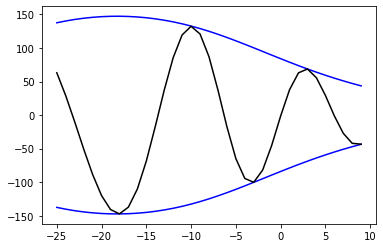

In [35]:
plt.plot(time_set,np.real(strainamp_series),color = 'blue')
plt.plot(time_set,np.real(-strainamp_series),color = 'blue')
plt.plot(time_set,np.real(strain_series),color = 'black')


In [36]:
print(t_peakpsi4_num)

-6.08606627483472
